In [1]:
import pandas as pd
import numpy as np

import pyarrow

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#!conda install -c conda-forge xgboost
import xgboost as xgb

%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from pickle import dump
from pickle import load

## Load the data

In [2]:
df = pd.read_parquet('client_database_preprocessed.parquet', engine='pyarrow')

In [3]:
oryg_shape = df.shape
oryg_shape

(1284, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 0 to 1283
Data columns (total 13 columns):
accepted               1284 non-null float64
gender                 1284 non-null float64
age                    1284 non-null float64
phone_calls            1284 non-null float64
emails                 1284 non-null float64
salary                 1284 non-null float64
estimated_expenses     1284 non-null float64
customer_type_C        1284 non-null float64
customer_type_Q        1284 non-null float64
customer_type_S        1284 non-null float64
offer_class_High       1284 non-null float64
offer_class_Medium     1284 non-null float64
offer_class_Premium    1284 non-null float64
dtypes: float64(13)
memory usage: 140.4 KB


In [5]:
df.head()

,accepted,gender,age,phone_calls,emails,salary,estimated_expenses,customer_type_C,customer_type_Q,customer_type_S,offer_class_High,offer_class_Medium,offer_class_Premium
0,1.0,0.0,0.177419,0.000,0.0,0.412503,0.517787,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,1.0,0.193548,0.125,0.2,0.295806,0.287459,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.193548,0.125,0.3,0.295806,0.089689,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.193548,0.125,0.2,0.295806,0.376244,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.112903,0.125,0.2,0.295806,0.173802,0.0,0.0,1.0,0.0,1.0,0.0


## Training and Validation Sets

In [6]:
# Randomize the dataset
seed = 123
np.random.seed(123)
index_list = list(df.index)
np.random.shuffle(index_list)
df = df.iloc[index_list]

# The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).
#df = df.sample(frac=1)

In [7]:
# Take the target variable out from the dataset
y = df.pop('accepted')

In [8]:
# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=seed)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1027, 12) (1027,)
(257, 12) (257,)


## Baseline

- Linear Algorithms: Logistic Regression.
- Nonlinear Algorithms: Classification and Regression Trees (CART), Support Vector Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [9]:
num_folds = 6
seed = 123

In [10]:
models = []
models.append(('LR', LogisticRegression(solver='lbfgs'))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC(gamma='scale')))
#models.append(('XGB', xgb.XGBClassifier(objective="binary:logistic", random_state=seed)))

In [11]:
def score_models(models, scoring):
    names = []
    results = []
    output = []
    
    for name, model in models:
        names.append(name)
        try:
            # Not all scoring metrics are available for all models
            
            kfold = KFold(n_splits=num_folds, random_state=seed)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            output.append('Model {}, mean accuracy {:0.2f}, (std. dev. {:0.2f})'.format(name, cv_results.mean(), cv_results.std()))
        except:
            output.append('Model {} {} metric unavailable)'.format(name, scoring))
        
    return output, results, names

In [12]:
# Classification Accuracy
scores, results, names = score_models(models, 'accuracy')
for score in scores:
    print(score)

Model LR, mean accuracy 0.78, (std. dev. 0.03)
Model KNN, mean accuracy 0.76, (std. dev. 0.03)
Model CART, mean accuracy 0.71, (std. dev. 0.02)
Model NB, mean accuracy 0.75, (std. dev. 0.05)
Model SVM, mean accuracy 0.79, (std. dev. 0.03)


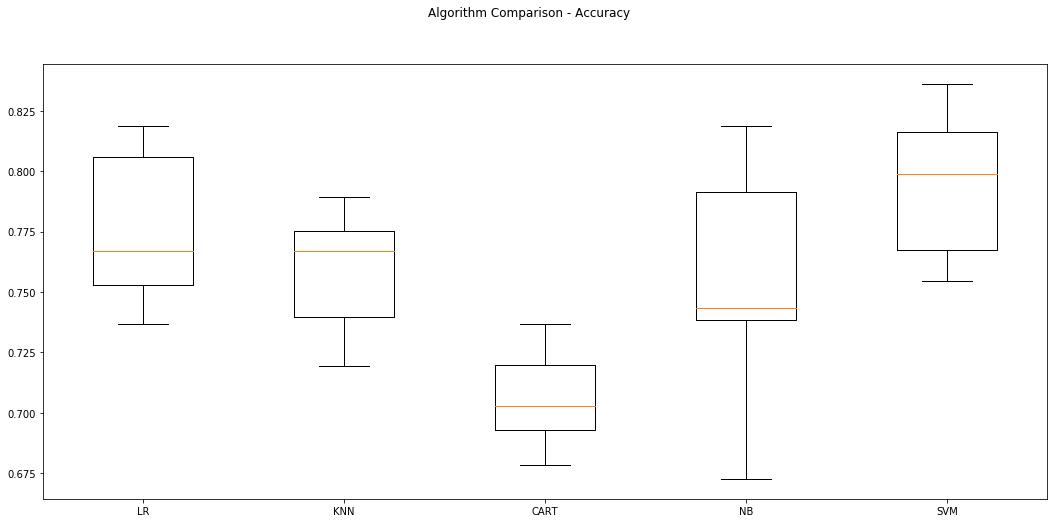

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(18,8))
fig.suptitle('Algorithm Comparison - Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

In [14]:
# Logarithmic Loss
scores, results, names = score_models(models, 'neg_log_loss')
for score in scores:
    print(score)

Model LR, mean accuracy -0.48, (std. dev. 0.04)
Model KNN, mean accuracy -2.25, (std. dev. 0.35)
Model CART, mean accuracy -10.36, (std. dev. 0.86)
Model NB, mean accuracy -0.84, (std. dev. 0.20)
Model SVM neg_log_loss metric unavailable)


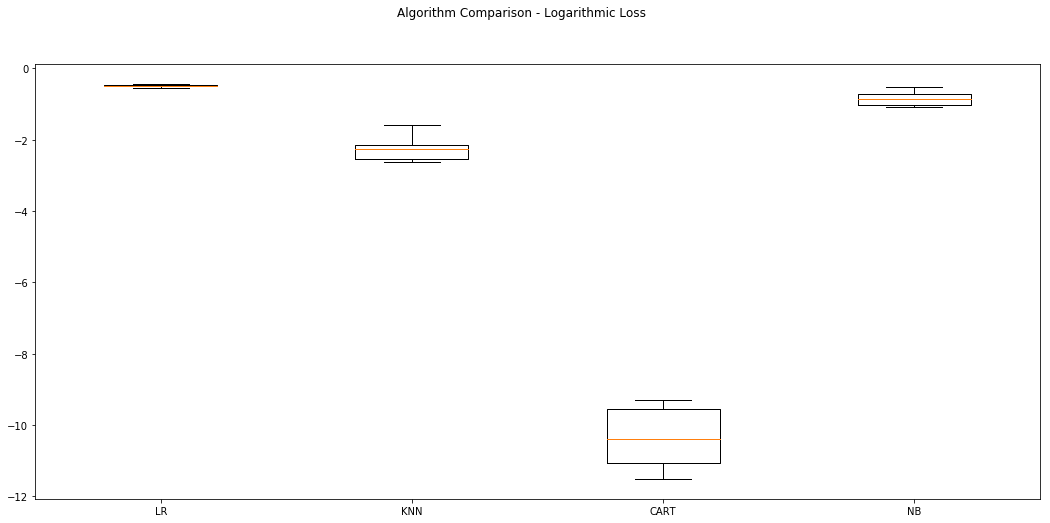

In [15]:
# Compare Algorithms
fig = plt.figure(figsize=(18,8))
fig.suptitle('Algorithm Comparison - Logarithmic Loss')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

In [16]:
# Area Under ROC Curve
# AUC should be close to 1 and greater than 0.5
scores, results, names = score_models(models, 'roc_auc')
for score in scores:
    print(score)

Model LR, mean accuracy 0.82, (std. dev. 0.03)
Model KNN, mean accuracy 0.79, (std. dev. 0.03)
Model CART, mean accuracy 0.69, (std. dev. 0.02)
Model NB, mean accuracy 0.79, (std. dev. 0.04)
Model SVM, mean accuracy 0.81, (std. dev. 0.03)


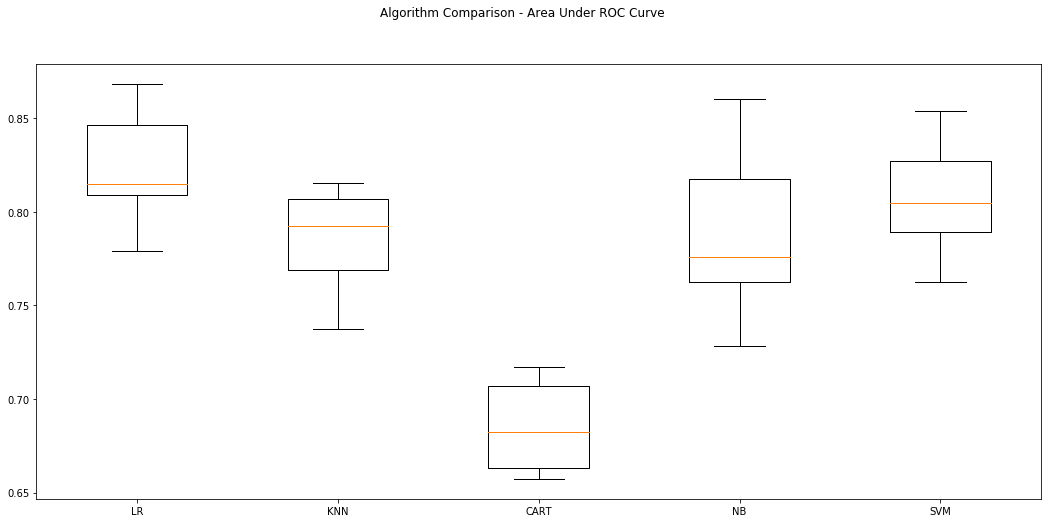

In [17]:
# Compare Algorithms
fig = plt.figure(figsize=(18,8))
fig.suptitle('Algorithm Comparison - Area Under ROC Curve')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

## Hyper-parameter Tuning

In [18]:
scoring = 'accuracy'

# Tune KNN
neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
param_grid = dict(n_neighbors=neighbors)

model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
print('-------')
print("Best: {:0.2f} using {}".format(grid_result.best_score_, grid_result.best_params_))

0.71 (0.01) with: {'n_neighbors': 1}
0.73 (0.02) with: {'n_neighbors': 3}
0.76 (0.03) with: {'n_neighbors': 5}
0.76 (0.03) with: {'n_neighbors': 7}
0.76 (0.03) with: {'n_neighbors': 9}
0.77 (0.03) with: {'n_neighbors': 11}
0.78 (0.02) with: {'n_neighbors': 13}
0.77 (0.03) with: {'n_neighbors': 15}
0.78 (0.03) with: {'n_neighbors': 17}
0.78 (0.03) with: {'n_neighbors': 19}
0.77 (0.03) with: {'n_neighbors': 21}
-------
Best: 0.78 using {'n_neighbors': 13}


In [19]:
# Tune SVM
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
param_grid = dict(C=c_values, kernel=kernel_values, gamma=gamma)

model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold) 
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
print('-------')
print("Best: {:0.2f} using {}".format(grid_result.best_score_, grid_result.best_params_))

0.77 (0.02) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.74 (0.06) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.77 (0.02) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.77 (0.02) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.77 (0.02) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
0.62 (0.03) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
0.77 (0.02) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.75 (0.01) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.77 (0.02) with: {'C': 0.3, 'gamma': 'scale', 'kernel': 'linear'}
0.77 (0.02) with: {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
0.78 (0.03) with: {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
0.77 (0.02) with: {'C': 0.3, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.77 (0.02) with: {'C': 0.3, 'gamma': 'auto', 'kernel': 'linear'}
0.62 (0.03) with: {'C': 0.3, 'gamma': 'auto', 'kernel': 'poly'}
0.77 (0.02) with: {'C': 0.3, 'gamma': 'auto', 'kernel': 'rbf'}
0.77 (0.02) with: {

## Ensemble methods
- Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
- Bagging Methods: Random Forests (RF) and Extra Trees (ET).

In [20]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=100)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=100)))

In [21]:
names = []
results = []

for name, model in ensembles:
    names.append(name)
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    print('Model {}, mean accuracy {:0.2f}, (std. dev. {:0.2f})'.format(name, cv_results.mean(), cv_results.std()))

Model AB, mean accuracy 0.76, (std. dev. 0.03)
Model GBM, mean accuracy 0.79, (std. dev. 0.03)
Model RF, mean accuracy 0.78, (std. dev. 0.02)
Model ET, mean accuracy 0.76, (std. dev. 0.02)


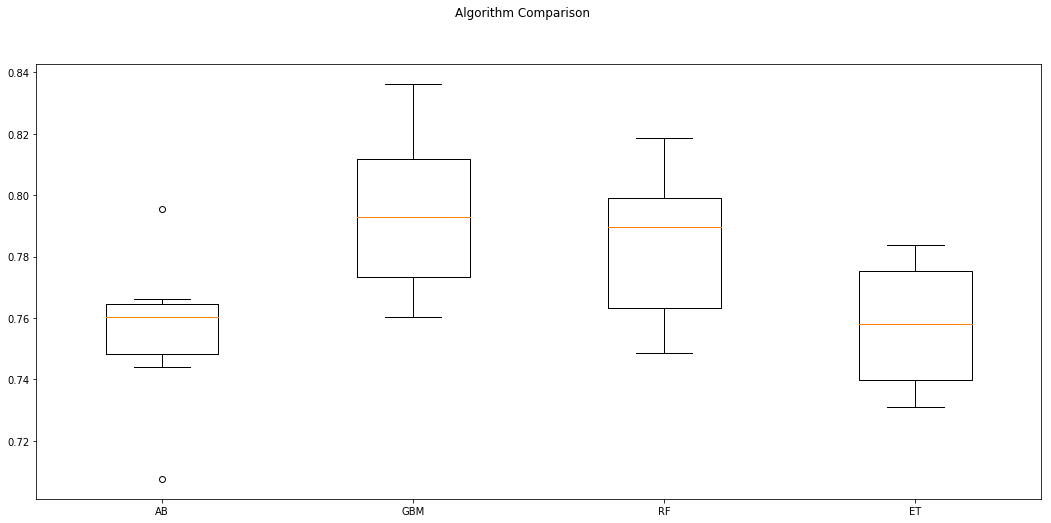

In [22]:
# Compare Algorithms
fig = plt.figure(figsize=(18,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

## Finalize model
Finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our finding

In [23]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

# Estimate accuracy on validation dataset
predictions = model.predict(X_test)

In [24]:
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8015564202334631
[[137  24]
 [ 27  69]]
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       161
         1.0       0.74      0.72      0.73        96

   micro avg       0.80      0.80      0.80       257
   macro avg       0.79      0.78      0.79       257
weighted avg       0.80      0.80      0.80       257



In [25]:
model = SVC(gamma='scale', C=0.7, kernel='rbf')
model.fit(X_train, y_train)

# Estimate accuracy on validation dataset
predictions = model.predict(X_test)

In [26]:
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8287937743190662
[[154   7]
 [ 37  59]]
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88       161
         1.0       0.89      0.61      0.73        96

   micro avg       0.83      0.83      0.83       257
   macro avg       0.85      0.79      0.80       257
weighted avg       0.84      0.83      0.82       257



## Train the final model on all available data

In [27]:
sh1 = X_train.shape
sh2 = X_test.shape
X_train = X_train.append(X_test, ignore_index=True)
sh1, sh2, X_train.shape

((1027, 12), (257, 12), (1284, 12))

In [28]:
sh1 = y_train.shape
sh2 = y_test.shape
y_train = y_train.append(y_test)
sh1, sh2, y_train.shape

((1027,), (257,), (1284,))

In [29]:
model.fit(X_train, y_train)

SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Save model to disk

In [30]:
# Save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [31]:
# Test
# Load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8287937743190662
